
# Headers



In [10]:
%matplotlib inline
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys
import pdb
import time


# Utility Functions



In [56]:
# Functions for initialization

def cleanupname(name):
    """
     The reaction names in the model files 
     don't have brackets or parentheses. I replaced
     those found in the mediaFluxes file.
     """
    name = name.replace('[', '__40__')#_LPAREN_')
    name = name.replace(']', '__41__')#'_RPAREN_')
    name = name.replace('(', '__40__')#'_LPAREN_')
    name = name.replace(')', '__41__')#'_RPAREN_')
    return name

def defineDFBAModel(SpeciesDict , MediaDF):
    print("Defining Dynamical model... \n")
    ParDef = dict()
    VarDef = dict()
    ICS = dict()
    exchange_list = []
    mediaDerivedComponents = {}
    for i, row in MediaDF.iterrows():
        N = cleanupname(row.Reaction)
        mediaDerivedComponents[N] = row['Flux Value'] / (24.0*60.0) # Per minute

    for species in SpeciesDict.keys():
        SpeciesDict[species]['SpeciesModel'] = cobra.io.read_sbml_model(SpeciesDict[species]['File'])
        SpeciesDict[species]['OriginalLB'] = {r.id:r.lower_bound for r in SpeciesDict[species]['SpeciesModel'].exchanges}
        SpeciesDict[species]['solution'] = SpeciesDict[species]['SpeciesModel'].optimize()
        SpeciesDict[species]['Name'] = SpeciesDict[species]['SpeciesModel'].name.split(' ')[0]
        exchange_list += SpeciesDict[species]['SpeciesModel'].exchanges
        Name=SpeciesDict[species]['Name']
        ParDef['mu' + '_' + Name] = SpeciesDict[species]['solution'].objective_value/60
        VarDef[Name] =  'mu_' + Name + ' * ' + Name + '- ' +'Dilution * ' + Name ### Biomass
        ICS[Name] = SpeciesDict[species]['initAbundance']
    ParDef['Dilution'] = 0.002
    all_exchanges = set()

    for ex in exchange_list:
        all_exchanges.add(ex.id)
        #     all_exchanges = list(set(exchange_list))

    for rid in all_exchanges:
        VarDef[rid] =  '-Dilution * ' + rid
        ICS[rid] = 0.1

        if rid in mediaDerivedComponents.keys():
            ParDef[rid + '_influx'] = mediaDerivedComponents[rid]
            VarDef[rid] += ' + ' +  rid + '_influx'

        for species in SpeciesDict.keys():
            # print(SpeciesDict[species]['Name'])
            if 'h2o' in rid:
                print(species, rid)
            if rid in [species_r.id for species_r in SpeciesDict[species]['SpeciesModel'].exchanges]:
                Name = SpeciesDict[species]['Name']
                ParDef[rid + '_' + Name] = SpeciesDict[species]['solution'].fluxes[rid]/60.0
                VarDef[rid] += ' + ' +  rid + '_' + Name + ' * ' + Name

    ModelDef = dst.args(name='Community',
                    pars=ParDef,
                        varspecs=VarDef,
                        ics=ICS)
    ModelDS = dst.Vode_ODEsystem(ModelDef)
    print("Done!")
    return (SpeciesDict, ModelDef, ModelDS)

# Functions for model updates

def recomputeLowerBounds(SpeciesDict, PrevSteadyState, Kmax):
    for species in SpeciesDict.keys():
        for rid in [rxn.id for rxn in SpeciesDict[species]['SpeciesModel'].exchanges]:
            SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid) \
                                                   .lower_bound = \
                                                                  SpeciesDict[species]['OriginalLB'][rid] \
                                                                  * PrevSteadyState[rid]/(Kmax+PrevSteadyState[rid])
    return SpeciesDict

def updateFluxParameters(SpeciesDict, ModelDS, PrevSteadyState, debug):
    ParDef = {}
    ICS = {}
    for species in SpeciesDict:
        solution = SpeciesDict[species]['SpeciesModel'].optimize()
        Name = SpeciesDict[species]['Name']
        ParDef['mu_' + Name] = solution.objective_value/60.0
        ICS[Name] = PrevSteadyState[Name]
        exchanges = [r.id for r in SpeciesDict[species]['SpeciesModel'].exchanges]
        for rid in exchanges:
            ParDef[rid + '_' + Name] = solution.fluxes[rid]/60.0
            ICS[rid] = PrevSteadyState[rid]
    ModelDS.set(pars=ParDef, ics=ICS)
    return ModelDS

def update(SpeciesDict, ModelDS, PrevSteadyState, Kmax,debug=False):
    UpdatedSpeciesDict = recomputeLowerBounds(SpeciesDict,
                                              PrevSteadyState, Kmax)

    UpdatedDynamicModel = updateFluxParameters(UpdatedSpeciesDict,
                                               ModelDS,
                                               PrevSteadyState,debug)
    # P = simulateModel(updatedDynamicalModel)
    return(UpdatedSpeciesDict, UpdatedDynamicModel)

def get_ss(PointSet):
    SSPoints={}
    for k in PointSet.keys():
        SSPoints[k]=PointSet[k][-1]
    return(SSPoints)

def checkNegativeMetabolites(PointSet,StoreNegatives):
    IndexStop = len(PointSet['t'])

    for variable in PointSet.keys():
        if any(PointSet[variable] < 0.0): # checking only final Tpoint, b/c monotonic
            varIndex = next((index for index,value in enumerate(list(PointSet[variable])) if value < 0.0), None)
            #varIndex= PointSet.index(filter(lambda x: x<0, PointSet)[0])
            if varIndex < IndexStop:
                # Update the index for the first negative crossing
                IndexStop = varIndex
               # print(IndexStop)

    if IndexStop < len(PointSet['t']) and IndexStop > 0:
        P_tilFirstNeg={}
        if len(P[variable] > IndexStop+5):
            Extension =5
        elif len(P[variable] > IndexStop+2):
            Extension =2
        else:
            Extension = 0
        for variable in PointSet.keys():
            P_tilFirstNeg[variable]=P[variable][:IndexStop] 
            if P[variable][IndexStop+Extension] < 0.0:
                P_tilFirstNeg[variable][IndexStop-1] = 0.0
                print('P_tillFirstNeg = ', P_tilFirstNeg[variable])
                StoreNegatives.add(variable)
                print(variable, 'is 0 at ', P['t'][IndexStop])
                
        P_tilFirstNeg['t'] = PointSet['t'][:IndexStop]
        PointSet = P_tilFirstNeg
    return(PointSet,StoreNegatives)


# Test:



In [14]:
# SpeciesDict = {'Sp1': {'File': './data/Bacteroides_sp_1_1_14.xml', 'initAbundance': 0.01},
#  'Sp10': {'File': './data/Desulfovibrio_piger_ATCC_29098.xml',
#   'initAbundance': 0.01},
#  'Sp2': {'File': './data/Ruminococcus_flavefaciens_FD_1.xml',
#   'initAbundance': 0.01},
#  'Sp3': {'File': './data/Lactobacillus_brevis_ATCC_367.xml',
#   'initAbundance': 0.01},
#  'Sp4': {'File': './data/Mycobacterium_avium_subsp_avium_ATCC_25291.xml',
#   'initAbundance': 0.01},
#  'Sp5': {'File': './data/Actinomyces_viscosus_C505.xml',
#   'initAbundance': 0.01},
#  'Sp6': {'File': './data/Exiguobacterium_aurantiacum_DSM_6208.xml',
#   'initAbundance': 0.01},
#  'Sp7': {'File': './data/Arcanobacterium_haemolyticum_DSM_20595.xml',
#   'initAbundance': 0.01},
#  'Sp8': {'File': './data/Streptococcus_intermedius_JTH08.xml',
#   'initAbundance': 0.01},
#  'Sp9': {'File': './data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
#   'initAbundance': 0.01}}
SpeciesDict = {'Sp1': {'File':'./data/Bacteroides_sp_1_1_14.xml',
                      'initAbundance':2e-3},
                'Sp2': {'File':'./data/Actinomyces_viscosus_C505.xml',
                        'initAbundance':2e-3},
               'Sp3': {'File':'./data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
                      'initAbundance':2e-3},
               'Sp4': {'File':'./data/Desulfovibrio_piger_ATCC_29098.xml',
                      'initAbundance':2e-3},
}


Defining Dynamical model... 

Sp2 EX_h2o__40__e__41__
Sp1 EX_h2o__40__e__41__
Sp4 EX_h2o__40__e__41__
Sp3 EX_h2o__40__e__41__
Done!


In [34]:
MediaDF = pd.read_csv('./data/VMH_HighFiber.tsv', sep='\t')

SpeciesDict, Definition, ModelDS = defineDFBAModel(SpeciesDict, MediaDF)
InitialValues = {k:[v] for (k,v) in Definition.ics.items()}
AllPoints = []
StoreNegatives = set()
P = InitialValues
T0=0
TEND = 1000
TSPAN = 50
Kmax=0.01
i=0
MaxIter= 1000
TERMINATE = False
starttime = time.clock()
# PrevT0=0
while T0 < TEND and i < MaxIter:
#and not TERMINATE:
    i+=1
    print('--------------------------------------------------------------')
    print('T0 = ' , T0, ' ; Iteration =', i)
   # print(P['EX_gln_L__40__e__41__'][-1])
    SpeciesDict, ModelDS = update(SpeciesDict, ModelDS, get_ss(P), Kmax)

    if T0+TSPAN > TEND:
        TSPAN = TEND - T0

    ModelDS.set(tdata=[T0, T0 + TSPAN])
    P = ModelDS.compute('test').sample() 
#     OldT = P['t'][-1]
#     # Initialize
    P, StoreNegatives = checkNegativeMetabolites(P,StoreNegatives) 
    T0 = P['t'][-1]
#     if T0=PrevT0:
#         debug=True
#         PrevT0
#     if OldT != T0:
#         TSPAN = 0.2
#     else:
#         TSPAN = 30
#     if len(P['t']) != 0:
#         T0 = P['t'][-1]
#     else:
#         TERMINATE = True

    AllPoints.append(P)
    for param in ModelDS.pars.keys():
        if 'asn' in param:
            print(param, ' = ', ModelDS.pars[param])

endtime = time.clock()
print('time of simulation = ' + str(endtime-starttime))


Defining Dynamical model... 

Sp2 EX_h2o__40__e__41__
Sp1 EX_h2o__40__e__41__
Sp4 EX_h2o__40__e__41__
Sp3 EX_h2o__40__e__41__
Done!
--------------------------------------------------------------
T0 =  0
P_tillFirstNeg =  [0.1        0.09997135 0.09994268 ... 0.00018338 0.00011305 0.        ]
EX_asn_L__40__e__41__ is 0 at  21.844368873774755
EX_asn_L__40__e__41___Actinomyces  =  -0.48799565955606516
EX_glyasn__40__e__41___Actinomyces  =  0.0
EX_asn_L__40__e__41___Bacteroides  =  -0.0678017912679161
EX_asn_L__40__e__41___Desulfovibrio  =  -0.7575757575757576
EX_glyasn__40__e__41___Desulfovibrio  =  0.0
EX_glyasn__40__e__41___Bifidobacterium  =  0.0
EX_asn_L__40__e__41___Bifidobacterium  =  -0.018804261916338563
--------------------------------------------------------------
T0 =  21.834366873374677
P_tillFirstNeg =  [1.12993361 1.1303079  1.13068208 ... 0.00516307 0.00324304 0.        ]
EX_asp_L__40__e__41__ is 0 at  61.0622124424885
EX_asn_L__40__e__41___Actinomyces  =  -0.0
EX_glyasn__4

KeyboardInterrupt: 

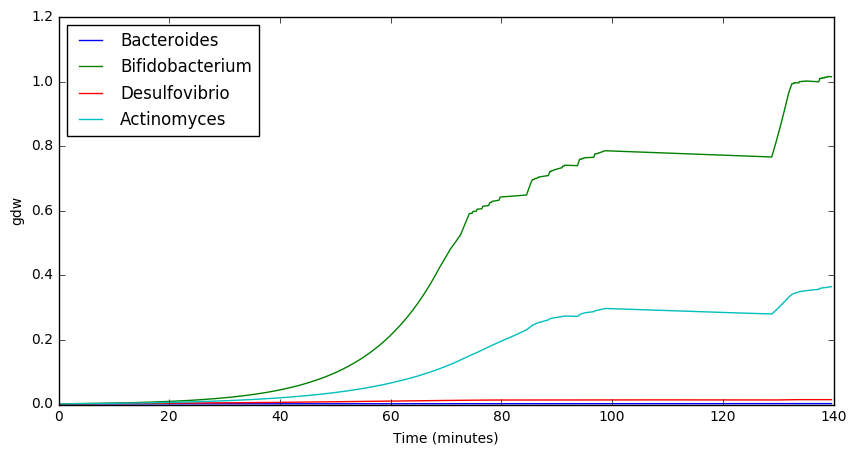

In [35]:
TimePoints={}
TimePoints['t'] =[]
plt.figure(figsize=(10,5))
for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for sp in SpeciesDict.keys():
    TimePoints[SpeciesDict[sp]['Name']] = []
    for P in AllPoints:
        TimePoints[SpeciesDict[sp]['Name']]+=list(P[SpeciesDict[sp]['Name']])

for k in TimePoints.keys():
    if k!= 't':
        plt.plot(TimePoints['t'], TimePoints[k], label=k)
        plt.xlabel('Time (minutes)')
        plt.ylabel('gdw')
plt.xlabel('Time (minutes)')
plt.ylabel('gdw')
plt.legend(loc=2)

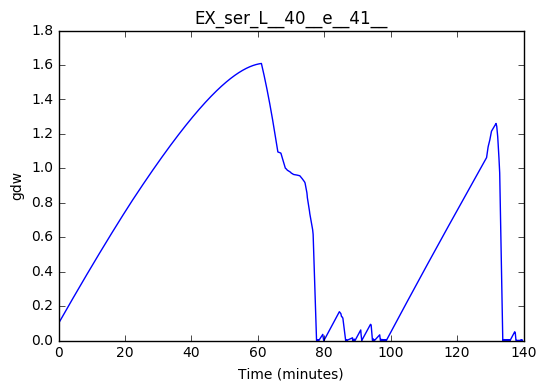

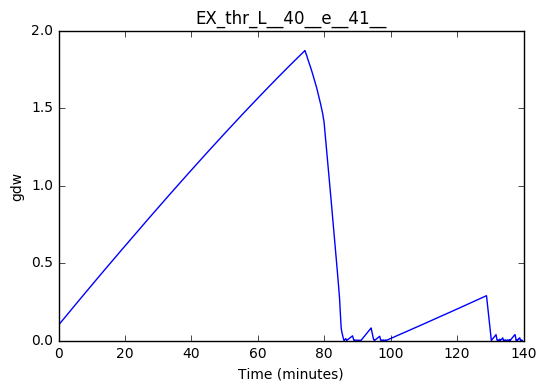

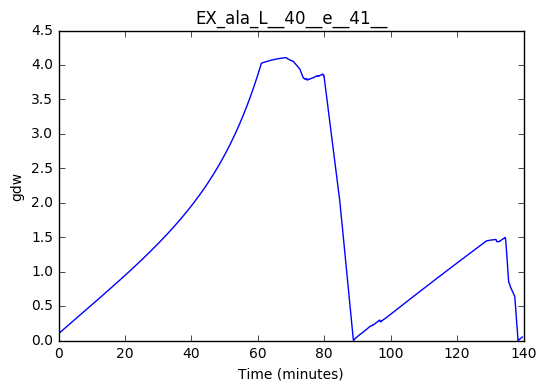

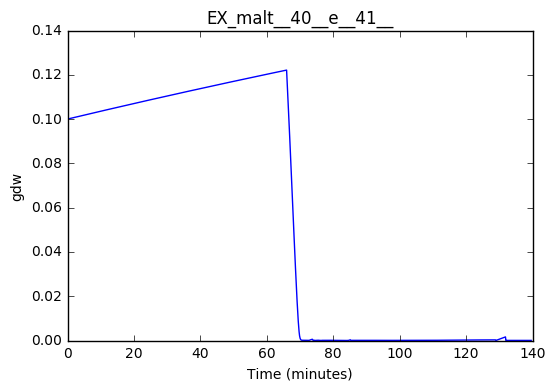

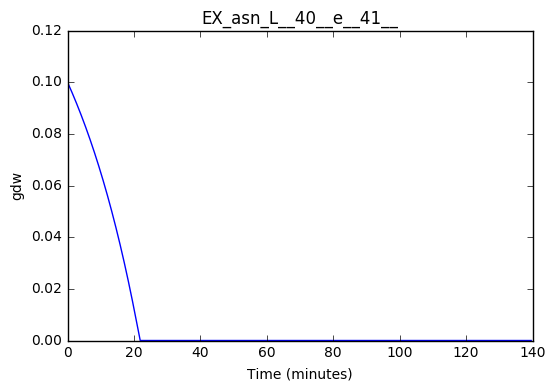

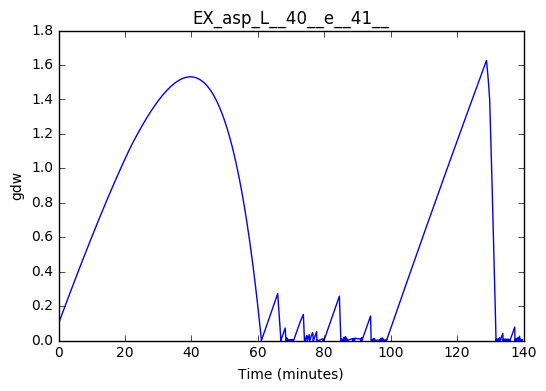

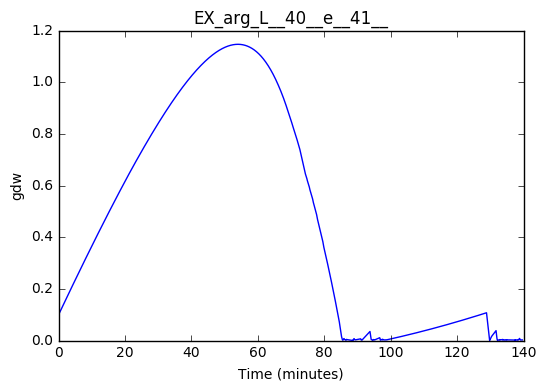

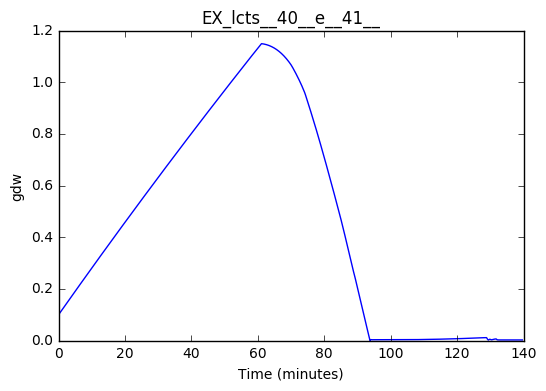

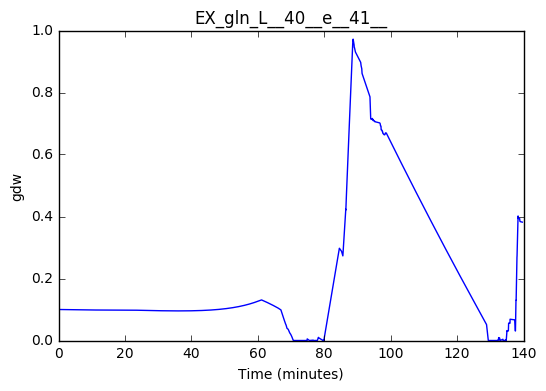

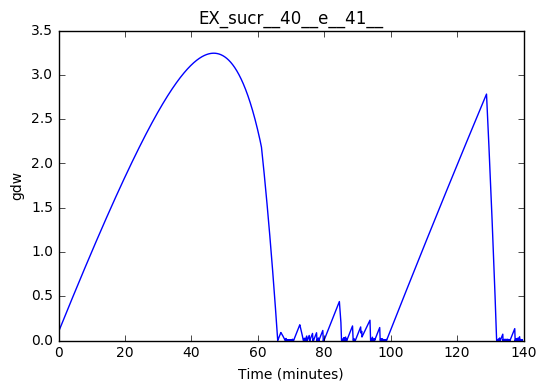

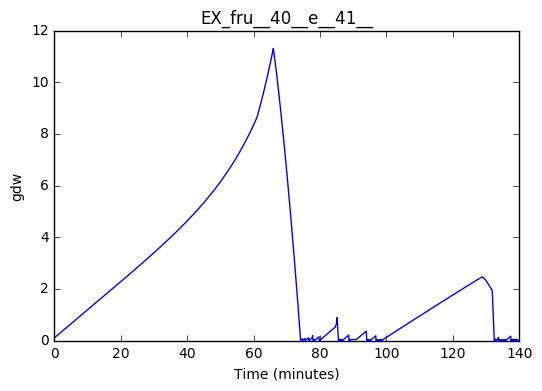

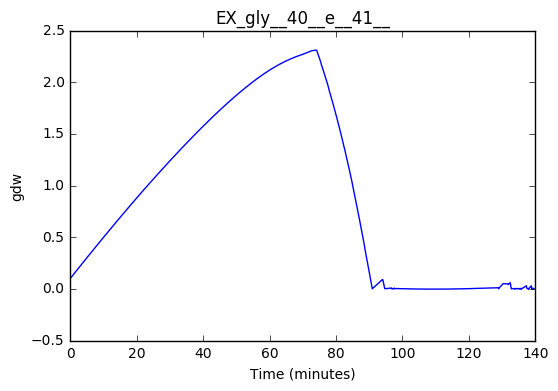

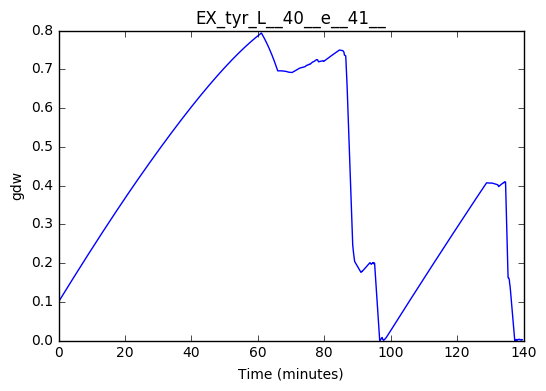

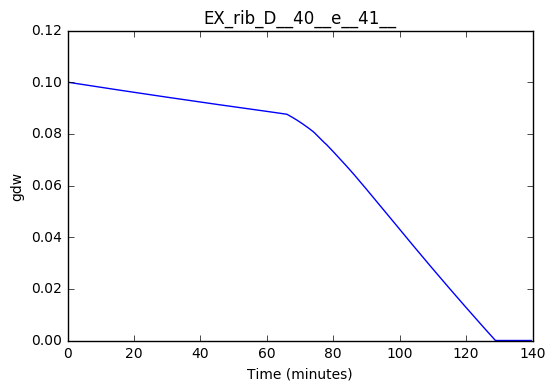

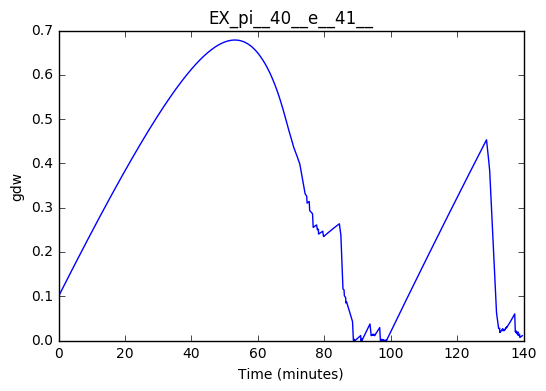

In [36]:
TimePoints={}
TimePoints['t'] =[]

for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for variable in StoreNegatives:
    TimePoints[variable] = []
    for P in AllPoints:
        TimePoints[variable]+=list(P[variable])

for k in TimePoints.keys():
    if k != 't':
        plt.figure()
        plt.plot(TimePoints['t'], TimePoints[k])
    else:
        continue
    plt.title(k)    
    plt.xlabel('Time (minutes)')
    #plt.ylim([0,0.5])
    plt.ylabel('gdw')

In [51]:
for i in range(0,len(AllPoints)):
    if any(AllPoints[i]['EX_gly__40__e__41__'] < 0):
        print(i)
        print (AllPoints[i]['t'])
        print(AllPoints[i]['EX_gly__40__e__41__'])


228
[ 98.71974395  98.72974595  98.73974795 ... 128.80576115 128.81576315
 128.82576515]
[0.00221835 0.00220895 0.00219956 ... 0.0122913  0.0123069  0.01232251]


In [52]:
[v for v in AllPoints[228]['EX_gly__40__e__41__']]

[0.00221834636586126,
 0.002208948034284851,
 0.0021995585211621576,
 0.002190177828029093,
 0.002180805954536543,
 0.0021714429003353818,
 0.0021620886650765285,
 0.002152743248410949,
 0.0021434066499895696,
 0.0021340788694633127,
 0.0021247599064831003,
 0.0021154497606999615,
 0.002106148431765298,
 0.002096855919330259,
 0.002087572223045996,
 0.0020782973425636213,
 0.002069031277534261,
 0.00205977402760904,
 0.0020505255924390844,
 0.0020412859716755194,
 0.0020320551649694704,
 0.0020228331719720507,
 0.002013619992334411,
 0.0020044156257076648,
 0.001995220071742937,
 0.001986033330091353,
 0.001976855400404039,
 0.00196768628233212,
 0.001958525975526722,
 0.0019493744796389573,
 0.0019402317943199774,
 0.001931097919220895,
 0.0019219728539928357,
 0.001912856598286925,
 0.0019037491517542885,
 0.001894650514046052,
 0.0018855606848133405,
 0.001876479663707267,
 0.0018674074503789828,
 0.0018583440444796006,
 0.0018492894456602462,
 0.0018402436535720447,
 0.001831206667

In [53]:
len(AllPoints[228]['EX_gly__40__e__41__'])

3011

In [25]:
{k:v for k,v in ModelDS.pars.iteritems() if 'asn' in ModelDS.pars[k]}

AttributeError: 'dict' object has no attribute 'iteritems'

In [21]:
type(ModelDS.pars)

dict

In [32]:
ModelDS.pars.keys()

dict_keys(['EX_fru__40__e__41___influx', 'EX_ptrc__40__e__41___Bacteroides', 'EX_glc_D__40__e__41___influx', 'EX_kestopt__40__e__41___Bifidobacterium', 'EX_metsox_S_L__40__e__41___Desulfovibrio', 'EX_acald__40__e__41___Actinomyces', 'EX_ttdca__40__e__41___influx', 'EX_arg_L__40__e__41___influx', 'EX_csn__40__e__41___Actinomyces', 'EX_na1__40__e__41___Desulfovibrio', 'EX_galt__40__e__41___Bacteroides', 'EX_ser_D__40__e__41___Actinomyces', 'EX_leu_L__40__e__41___influx', 'EX_xan__40__e__41___Bifidobacterium', 'EX_hxan__40__e__41___Desulfovibrio', 'EX_pydam__40__e__41___Actinomyces', 'EX_arabttr__40__e__41___Bifidobacterium', 'EX_no2__40__e__41___Bacteroides', 'EX_ttdca__40__e__41___Desulfovibrio', 'EX_alaglu__40__e__41___Actinomyces', 'EX_his_L__40__e__41___Bifidobacterium', 'EX_glyasp__40__e__41___Bifidobacterium', 'EX_cl__40__e__41___Bifidobacterium', 'EX_alahis__40__e__41___Bifidobacterium', 'EX_ins__40__e__41___Bacteroides', 'EX_nac__40__e__41___Desulfovibrio', 'EX_ala_L__40__e__41__

In [55]:
Start =time.clock()
print(any(AllPoints[228]['EX_gly__40__e__41__'] < 0.0))
print(time.clock()-Start)

Start =time.clock()
print(AllPoints[228]['EX_gly__40__e__41__'][-1] < 0.0)
print(time.clock()-Start)

True
0.0004850749646720942
False
0.0001910718438011827
